# Data extraction

In [15]:
import os
os.chdir('/Users/hanliyang/Documents/GitHub/Parkinson-Prediagnosis')

In [16]:
import cv2
import mediapipe as mp
import pandas as pd
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from utils.draw_landmarks import draw_landmarks_on_image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BASE_DIR = os.path.abspath("..")
# Create a HandLandmarker object
base_options = python.BaseOptions(model_asset_path='../hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

video_path = "../images/neg1.mp4"
cap = cv2.VideoCapture(video_path)

landmarks_data = []

frame_number = 0  # To keep track of frame number
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"Processing Video...")
        break

    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to Mediapipe
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # Detect hand landmarks from the input image
    detection_result = detector.detect(mp_image)

    # Process the classification result
    annotated_frame = draw_landmarks_on_image(frame_rgb, detection_result)
    
    # Extract landmarks
    if detection_result.hand_landmarks:
        for hand_landmarks in detection_result.hand_landmarks:
            for idx, landmark in enumerate(hand_landmarks):
                landmarks_data.append({
                    'Frame': frame_number,
                    'Landmark Index': idx,
                    'X': landmark.x,
                    'Y': landmark.y,
                    'Z': landmark.z
                })

    # Display the annotated frame
    annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('Hand Landmarks', annotated_frame_bgr)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_number += 1

cap.release()
cv2.destroyAllWindows()

# Create DataFrame
landmarks = pd.DataFrame(landmarks_data)
print(landmarks)
landmarks.info()


I0000 00:00:1731474090.838048 2333127 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1731474090.868202 2336285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731474090.895119 2336278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731474091.081675 2336282 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/hanliyang/Documents/GitHub/Parkinson-Prediagnosis/venv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetP

Processing Video...
       Frame  Landmark Index         X         Y         Z
0          0               0  0.048391  0.638838  0.000001
1          0               1  0.297199  0.688729 -0.067851
2          0               2  0.507608  0.681672 -0.092657
3          0               3  0.691438  0.639847 -0.105803
4          0               4  0.844060  0.634728 -0.115737
...      ...             ...       ...       ...       ...
22843   1087              16  0.409972  0.241035 -0.160369
22844   1087              17  0.196409  0.470629 -0.027934
22845   1087              18  0.161077  0.387943 -0.069179
22846   1087              19  0.131346  0.340614 -0.110235
22847   1087              20  0.104642  0.301339 -0.139160

[22848 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22848 entries, 0 to 22847
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frame           22848 non-null  int64  
 1 

# Computing Change in Velocity from Generated Video df

In [ ]:
fps = 30
time_per_frame = 1/fps

# Convert values to float
#df['X'] = df['X'].astype(float)
#df['Y'] = df['Y'].astype(float)
#df['Z'] = df['Z'].astype(float)

# Sort the df by landmark index
landmarks = landmarks.sort_values(by=['Frame', 'Landmark Index'])

# Calcualte the displacement by frame of landmark index
landmarks['dX'] = landmarks.groupby('Landmark Index')['X'].diff()
landmarks['dY'] = landmarks.groupby('Landmark Index')['Y'].diff()
landmarks['dZ'] = landmarks.groupby('Landmark Index')['Z'].diff()

# Calculate magnitude of displcemnt in 3d space
landmarks['dPosition'] = np.sqrt(landmarks['dX']**2 + landmarks['dY']**2 + landmarks['dZ']**2)
landmarks['Velocity'] = np.sqrt(landmarks['dX']**2 + landmarks['dY']**2 + landmarks['dZ']**2)/ time_per_frame

# Calculate the change in acceleration
landmarks['Acceleration'] = landmarks.groupby('Landmark Index')['Velocity'].diff()

landmarks = landmarks.dropna()

landmarks.to_csv('landmarks_pos1.csv', index=False)  # Save DataFrame to CSV
landmarks.head()



NameError: name 'df' is not defined

In [17]:
landmarks = pd.read_csv("CV_Hand_Model/Data/landmarks_pos1.csv")

### Analyze the Data

In [19]:

# Averages
avgdPos = landmarks['dPosition'].mean()
avgVel = landmarks['Velocity'].mean()
avgdAcc = landmarks['Acceleration'].mean()

print(f"{avgdPos}")
print(f"{avgVel}")
print(f"{avgdAcc}")


0.01856874163665175
0.5570622490995539
0.00011600078528125768


### Creating Graphs

<function matplotlib.pyplot.show(close=None, block=None)>

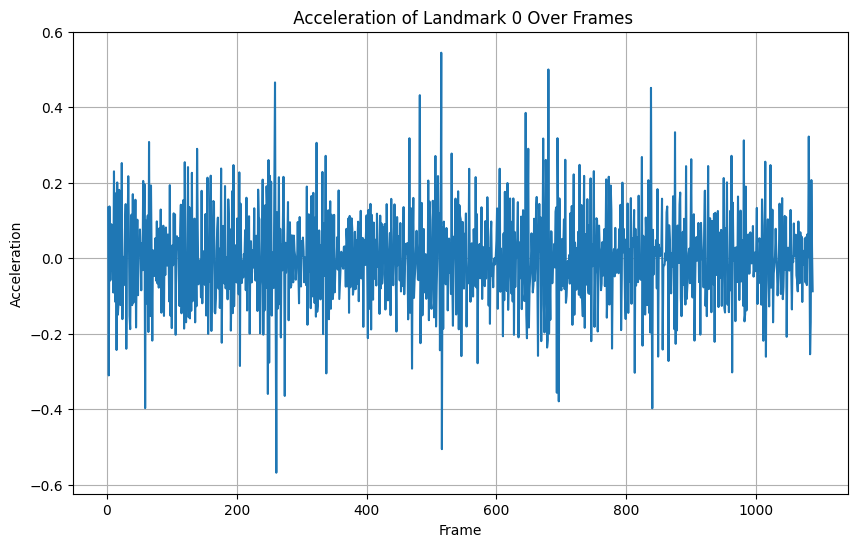

In [20]:
# BASIC GRAPH
import matplotlib.pyplot as plt

landmark_index = 0

landmark_data = landmarks[landmarks['Landmark Index'] == landmark_index]

plt.figure(figsize=(10,6))
plt.plot(landmark_data['Frame'], landmark_data['Acceleration'], label=f'Landmark {landmark_index}')
plt.xlabel('Frame')
plt.ylabel('Acceleration')
plt.title(f' Acceleration of Landmark {landmark_index} Over Frames')
plt.grid(True)

plt.show

#

/var/folders/02/s2pnfmx100v3128rbky3w3mr0000gn/T/ipykernel_85595/931772498.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmark_data['Moving_Average'] = landmark_data['Acceleration'].rolling(window=window_size).mean()


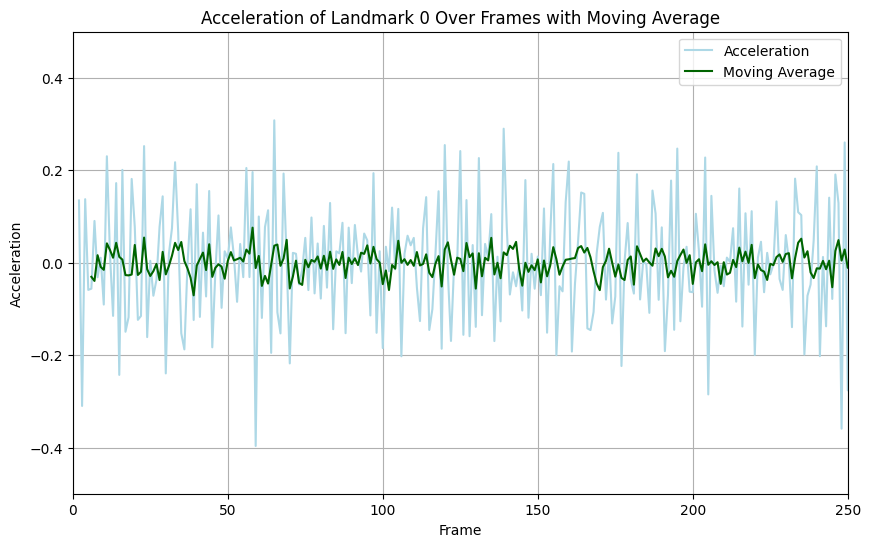

In [21]:
# GRAPH WITH AVERAGE

def plot_acceleration_with_moving_average(landmarks, landmark_index, window_size=5, x_range=None, y_range=None):
    """
    Plots the acceleration of a specified landmark over frames with a moving average trendline.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        landmark_index (int): The index of the landmark to plot.
        window_size (int): The size of the moving average window.
    """
    # Filter the DataFrame for the selected landmark
    landmark_data = landmarks[landmarks['Landmark Index'] == landmark_index]

    # Calculate moving average
    landmark_data['Moving_Average'] = landmark_data['Acceleration'].rolling(window=window_size).mean()

    # Plot acceleration and moving average
    plt.figure(figsize=(10, 6))
    plt.plot(landmark_data['Frame'], landmark_data['Acceleration'], label='Acceleration', color='lightblue')
    plt.plot(landmark_data['Frame'], landmark_data['Moving_Average'], label='Moving Average', color='darkgreen', linestyle='-')

    # Add labels and title
    plt.xlabel('Frame')
    plt.ylabel('Acceleration')
    plt.title(f'Acceleration of Landmark {landmark_index} Over Frames with Moving Average')
    plt.legend()
    plt.grid(True)

    # Set the x-axis limit if x_range is provided
    if x_range is not None:
        plt.xlim(x_range)
    
    # Set the y-axis limit if y_range is provided
    if y_range is not None:
        plt.ylim(y_range)

    # Show the plot
    plt.show()

# Example usage
plot_acceleration_with_moving_average(landmarks, landmark_index=0, x_range=(0,250), y_range=(-0.5, 0.5))  # Replace 0 with your desired landmark index


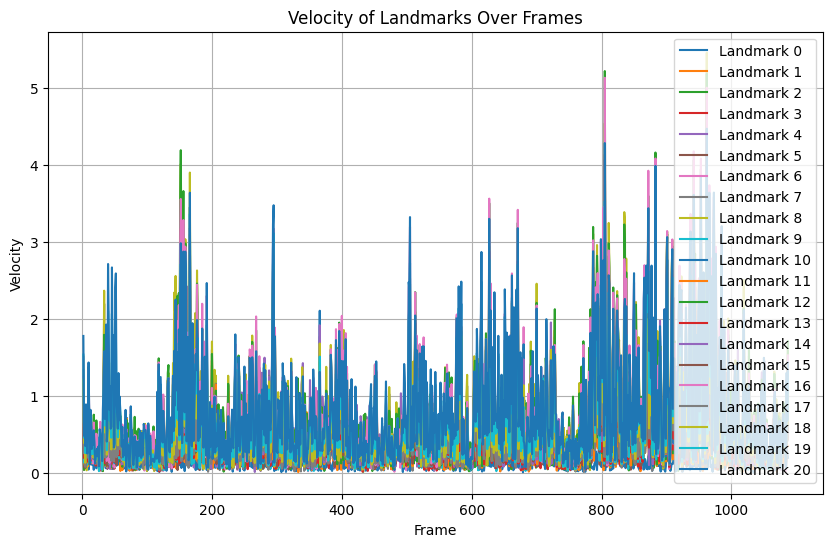

In [22]:
# ALL LANDMARKS

# Plot velocity for each landmark
plt.figure(figsize=(10, 6))

# Loop through each landmark and plot its velocity
for landmark in landmarks['Landmark Index'].unique():
    landmark_data = landmarks[landmarks['Landmark Index'] == landmark]
    plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label=f'Landmark {landmark}')

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Velocity of Landmarks Over Frames')
plt.legend()  # Add a legend to differentiate between landmarks
plt.grid(True)

# Show the plot
plt.show()
